# CV Assignment 4: Q1 Perform image classification using CNN on the MNIST dataset.

## Checking Avilable GPU

In [1]:
!nvidia-smi

Sat Apr 22 04:06:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   55C    P8    32W / 350W |    721MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Importing requirements

In [2]:
# pytorch libs
import torch
from torch import nn
import torchvision

# matplot libs
import matplotlib.pyplot as plt

# numpy
import numpy as np

# torch metrics
try:
  import torchmetrics
except:
  !pip3 -q install torchmetrics
finally:
  from torchmetrics.classification import Accuracy

try:
  import torchinfo
except:
  !pip3 -q install torchinfo
finally:
  from torchinfo import summary

## device agnostic code

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Getting Dataset with pytorch


### Downloading the dataset

In [4]:
from torchvision import transforms

data_transforms_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

data_transforms_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])


train_dataset = torchvision.datasets.MNIST(root='data', train=True, download=True, transform=data_transforms_train)
test_dataset = torchvision.datasets.MNIST(root='data', train=False, download=True, transform=data_transforms_test)

train_dataset,test_dataset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: Compose(
                Grayscale(num_output_channels=3)
                ToTensor()
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: Compose(
                Grayscale(num_output_channels=3)
                ToTensor()
            ))

In [5]:
print(f"shape of 1st image in train dataset: {train_dataset[0][0].shape}")

shape of 1st image in train dataset: torch.Size([3, 28, 28])


### Vis. dataset (train dataset)

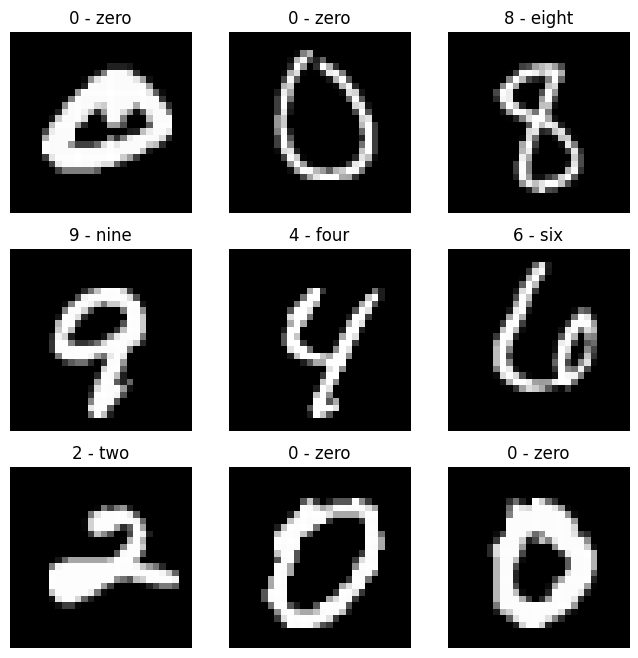

In [6]:
# randomly ploting image samples from the grayscale dataset
classes = train_dataset.classes
labels_map = {classes[i]:i for i in range(10)}  # getting class -> index map
labels_map = dict(map(reversed, labels_map.items()))  # inverting dict
# print(labels_map)

figure = plt.figure(figsize=(8, 8))  # fixing plotsize
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(
        len(train_dataset), size=(1,)
    )  # randomely selecting one image sample from the image index
    img, label = train_dataset[sample_idx.item()]  # getting image and label of selected index
    # sub plot code
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    if len(img.shape) == 3 and img.shape[0] == 3:
        plt.imshow(
            img.permute(1, 2, 0)
        )  # NOTE:- Color map is gray because we're converting imgae to grayscale / changing channel to HWC for color image
    else:
        plt.imshow(img.squeeze(), cmap="gray")
    # sub plot code ends
plt.show()
# NOTE: WARRING BECAUSE OF auto_transforms

### Converting dataset to dataloader

In [7]:
import os

# hyper parms. for dataloader
BATCH_SIZE = 128
NUM_WORKERS = 4  # no. of avilable cpu cores

# train dataloader
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)

# test dataloader
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

print(f"Numbers of Batches in Train Dataloader: {len(train_dataloader)}")
print(f"Numbers of Batches in Test Dataloader: {len(test_dataloader)}")
# train_dataloader,test_dataloader

Numbers of Batches in Train Dataloader: 469
Numbers of Batches in Test Dataloader: 79


## Model Defination

### Custom Arch.

In [8]:
# Create a convolutional neural network 
class MNISTModel(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block_3 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*3*3, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.block_3(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

def get_custom_model():
    model_conv = MNISTModel(input_shape=3, 
        hidden_units=32, 
        output_shape=10).to(device)
    return model_conv

### ResNet-34

In [9]:
from torchvision.models import resnet18
# Model with pretrained weights Architecture - Resnet18resnet18
def get_resnet_model():
    model_resnet = resnet18()

    model_resnet.fc = nn.Linear(512, 10)
    
    return model_resnet

## Models Training Utils Functions

### Plot loss curves of a model

In [10]:
# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()

### making training, testing steps, train model functions

#### train step

In [11]:
def training_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    device: str,
    profiler: torch.profiler.profile = None,
):
    """
    Desc:
      funtion to perform traning step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      optimizer (torch.optim.Optimizer): Optimizer Function (object) of your choice
      device (str): Torch Device "CPU/GPU"
      profiler (torch.profiler.profile, optional): Pytorch Profiler. Defaults to None.
    Returns:
      train_loss (float), train_acc (float): training loss and training accuracy for one EPOCH
    """
    model.train()  # putting model in traing model

    train_loss, train_acc = 0, 0  # initlizing loss and acc. for the epoch

    if profiler != None:
      profiler.start()
      for step,(X, y) in enumerate(dataloader):  # loop in batches
        if step >= (1 + 1 + 3) * 2:
          break
        X, y = X.to(device), y.to(device)  # sending the data to target device
        # print(f"shape of X: {X.shape}, shape of y: {y.shape}")
        
        # 1. forward pass
        y_pred_logits = model(X)
        # y_pred = y_pred_logits.argmax(dim=1).type(torch.int)
        # print(y_pred)
        # 2. calculate the loss
        loss = loss_fn(y_pred_logits, y)
        train_loss += loss.item()

        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backword
        loss.backward()

        # 5. optimizer step
        optimizer.step()
        
        train_acc += acc_fn(y_pred_logits, y).item()
        
        profiler.step()
      profiler.stop()
    else:
      for step,(X, y) in enumerate(dataloader):  # loop in batches
        X, y = X.to(device), y.to(device)  # sending the data to target device
        # print(f"shape of X: {X.shape}, shape of y: {y.shape}")
        
        # 1. forward pass
        y_pred_logits = model(X)
        # y_pred = y_pred_logits.argmax(dim=1).type(torch.int)
        # print(y_pred)
        # 2. calculate the loss
        loss = loss_fn(y_pred_logits, y)
        train_loss += loss.item()

        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backword
        loss.backward()

        # 5. optimizer step
        optimizer.step()
        
        train_acc += acc_fn(y_pred_logits, y).item()
    # 6. returning actual loss and acc.x
    return train_loss / len(dataloader), train_acc / len(dataloader)

#### test step

In [12]:
def testing_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    device: str,
):
    """
    Desc:
      funtion to perform testing step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): testing dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
    Returns:
      test_loss (float), test_acc (float): testing loss and testing accuracy for one EPOCH
    """
    model.eval()  # putting model in eval model

    test_loss, test_acc = 0, 0  # initlizing loss and acc. for the epoch

    # with torch.inference_mode(): # disabling inference mode for aqcuiring gradients of perturbed data
    for (X, y) in dataloader:  # loop in batches
        X, y = X.to(device), y.to(device)  # sending the data to target device
        # print(f"shape of X: {X.shape}, shape of y: {y.shape}")

        # 1. forward pass
        y_pred_logits = model(X)

        # 2. calculate the loss
        loss = loss_fn(y_pred_logits, y)
        test_loss += loss.item()

        # printing the prediction and actual label
        # print(y_pred_logits.argmax(dim=1), y,sep='\n')
        
        # 3. calculating accuracy
        test_acc += acc_fn(y_pred_logits, y).item()

    # 6. returning actual loss and acc.
    return test_loss / len(dataloader), test_acc / len(dataloader)

#### training function

In [13]:
from tqdm.auto import tqdm


def train(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    save_info: str,
    profiler:torch.profiler.profile = None,
):
    """
    Desc:
      funtion to perform training for one {epochs} param

    Args:
      model (nn.Module): Pytorch model class object
      train_dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      test_dataloader (torch.utils.data.DataLoader): testing dataloder from testing dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
      epochs (int): number of epochs to train the model
      save_info (str): info for saving model
      profiler (torch.profiler.profile, optional): Pytorch Profiler. Defaults to None.
    Returns:
      result_dict ({str: List[float]}): testing loss and testing accuracy for one EPOCH
    """
    # 1. init. result dict
    result_dict = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    best_test_acc = 0
    best_model_params = None

    # 2. loop in range epochs performs train and test steps on the model
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = training_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            acc_fn=acc_fn,
            optimizer=optimizer,
            device=device,
            profiler=profiler,
        )

        test_loss, test_acc = testing_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            acc_fn=acc_fn,
            device=device,
        )

        # 3. print out results
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 4. adding results to result_dict
        result_dict["train_loss"].append(train_loss)
        result_dict["train_acc"].append(train_acc)
        result_dict["test_loss"].append(test_loss)
        result_dict["test_acc"].append(test_acc)
        
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_model_params = model.state_dict()

    # 5. saving the best model
    torch.save(best_model_params, f"{model.__class__.__name__}_epoch_{epochs}_optim_adam_"+save_info+".pth")
    # 6. return result dict
    return result_dict

## Training the models

### Training Models

In [66]:
# # Hyperparms
lr = [1e-3,1e-4] # learning rate
betas=[(0.8, 0.888),(0.9, 0.999)] # coefficients used for computing running averages of gradient and its square
eps = [1e-8] # term added to the denominator to improve numerical stability
weight_decay = [1e-3] # weight decay (L2 penalty)
epoches = [10,20]

parms_combs = [(l,b,e,w_d,epoch) for l in lr for b in betas for e in eps for w_d in weight_decay for epoch in epoches]
# print(parms_combs)


# init. loss function, accuracy function and optimizer
loss_fn = nn.CrossEntropyLoss()
acc_fn = Accuracy(task="multiclass", num_classes=10).to(device=device)

### Training Custom Arch.

current exp / total: 1 / 8
Training with: lr: 0.001, betas: (0.8, 0.888), eps: 1e-08, weight_decay: 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3282 | train_acc: 0.8915 | test_loss: 0.0813 | test_acc: 0.9746
Epoch: 2 | train_loss: 0.0671 | train_acc: 0.9792 | test_loss: 0.0460 | test_acc: 0.9849
Epoch: 3 | train_loss: 0.0466 | train_acc: 0.9855 | test_loss: 0.0419 | test_acc: 0.9881
Epoch: 4 | train_loss: 0.0385 | train_acc: 0.9880 | test_loss: 0.0284 | test_acc: 0.9908
Epoch: 5 | train_loss: 0.0316 | train_acc: 0.9902 | test_loss: 0.0264 | test_acc: 0.9913
Epoch: 6 | train_loss: 0.0297 | train_acc: 0.9907 | test_loss: 0.0283 | test_acc: 0.9915
Epoch: 7 | train_loss: 0.0274 | train_acc: 0.9912 | test_loss: 0.0288 | test_acc: 0.9905
Epoch: 8 | train_loss: 0.0256 | train_acc: 0.9918 | test_loss: 0.0279 | test_acc: 0.9911
Epoch: 9 | train_loss: 0.0252 | train_acc: 0.9919 | test_loss: 0.0256 | test_acc: 0.9916
Epoch: 10 | train_loss: 0.0234 | train_acc: 0.9923 | test_loss: 0.0393 | test_acc: 0.9874
total training time: 36.013 sec.
LOSS & Accuracy Curves
lr: 0.001, betas: (0.8, 0.888), eps: 1e-08, weight_de

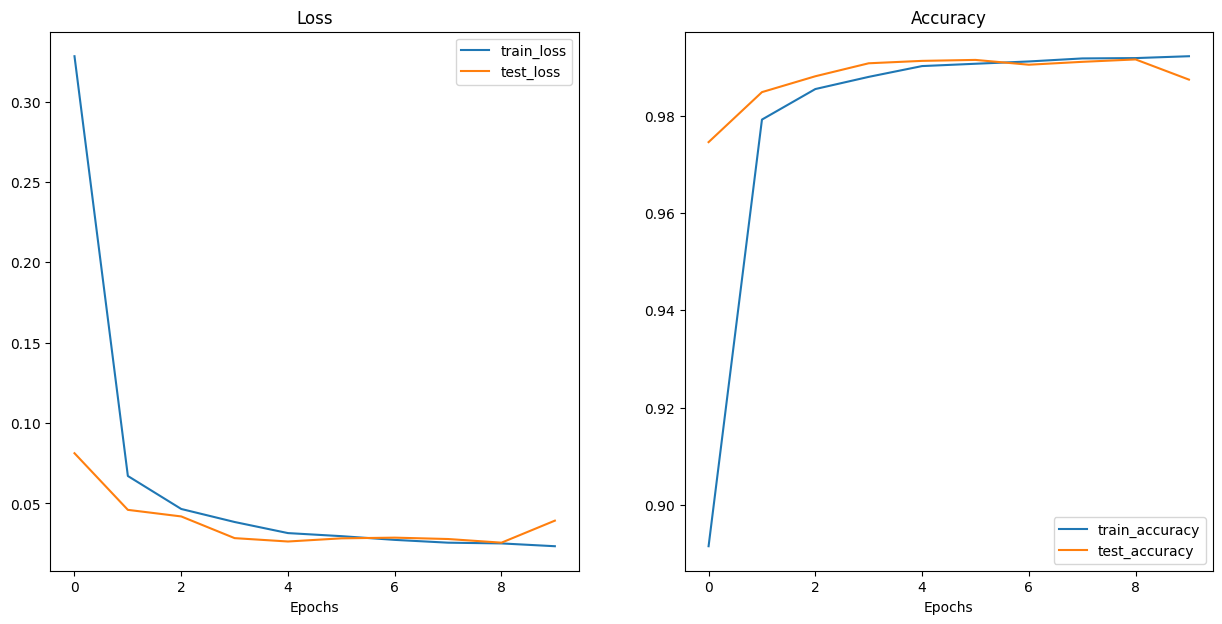


current exp / total: 2 / 8
Training with: lr: 0.001, betas: (0.8, 0.888), eps: 1e-08, weight_decay: 0.001


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3140 | train_acc: 0.8985 | test_loss: 0.0642 | test_acc: 0.9801
Epoch: 2 | train_loss: 0.0649 | train_acc: 0.9801 | test_loss: 0.0364 | test_acc: 0.9894
Epoch: 3 | train_loss: 0.0461 | train_acc: 0.9858 | test_loss: 0.0291 | test_acc: 0.9897
Epoch: 4 | train_loss: 0.0380 | train_acc: 0.9880 | test_loss: 0.0410 | test_acc: 0.9861
Epoch: 5 | train_loss: 0.0331 | train_acc: 0.9898 | test_loss: 0.0258 | test_acc: 0.9911
Epoch: 6 | train_loss: 0.0298 | train_acc: 0.9905 | test_loss: 0.0376 | test_acc: 0.9882
Epoch: 7 | train_loss: 0.0286 | train_acc: 0.9910 | test_loss: 0.0244 | test_acc: 0.9915
Epoch: 8 | train_loss: 0.0263 | train_acc: 0.9916 | test_loss: 0.0261 | test_acc: 0.9912
Epoch: 9 | train_loss: 0.0245 | train_acc: 0.9919 | test_loss: 0.0301 | test_acc: 0.9898
Epoch: 10 | train_loss: 0.0235 | train_acc: 0.9924 | test_loss: 0.0285 | test_acc: 0.9911
Epoch: 11 | train_loss: 0.0226 | train_acc: 0.9926 | test_loss: 0.0282 | test_acc: 0.9904
Epoch: 12 | train_l

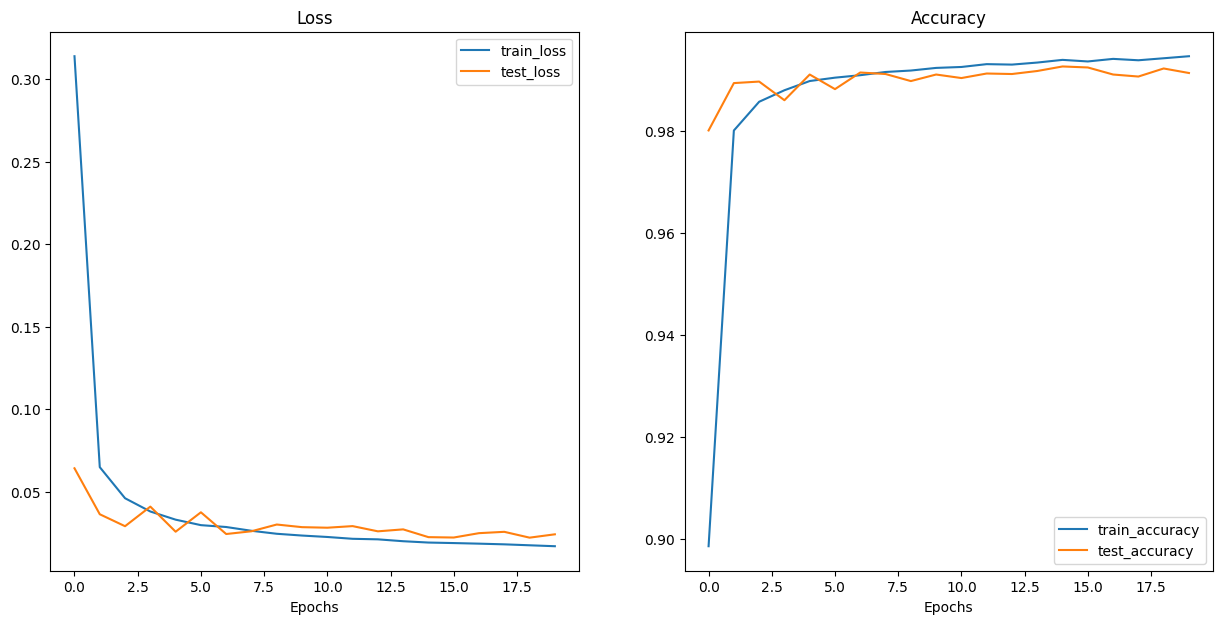


current exp / total: 3 / 8
Training with: lr: 0.001, betas: (0.9, 0.999), eps: 1e-08, weight_decay: 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3209 | train_acc: 0.8929 | test_loss: 0.0597 | test_acc: 0.9794
Epoch: 2 | train_loss: 0.0704 | train_acc: 0.9782 | test_loss: 0.0446 | test_acc: 0.9850
Epoch: 3 | train_loss: 0.0509 | train_acc: 0.9838 | test_loss: 0.0501 | test_acc: 0.9827
Epoch: 4 | train_loss: 0.0399 | train_acc: 0.9876 | test_loss: 0.0392 | test_acc: 0.9873
Epoch: 5 | train_loss: 0.0367 | train_acc: 0.9882 | test_loss: 0.0358 | test_acc: 0.9880
Epoch: 6 | train_loss: 0.0314 | train_acc: 0.9899 | test_loss: 0.0418 | test_acc: 0.9867
Epoch: 7 | train_loss: 0.0305 | train_acc: 0.9901 | test_loss: 0.0359 | test_acc: 0.9879
Epoch: 8 | train_loss: 0.0280 | train_acc: 0.9907 | test_loss: 0.0483 | test_acc: 0.9854
Epoch: 9 | train_loss: 0.0267 | train_acc: 0.9912 | test_loss: 0.0449 | test_acc: 0.9863
Epoch: 10 | train_loss: 0.0247 | train_acc: 0.9920 | test_loss: 0.0403 | test_acc: 0.9871
total training time: 35.578 sec.
LOSS & Accuracy Curves
lr: 0.001, betas: (0.9, 0.999), eps: 1e-08, weight_de

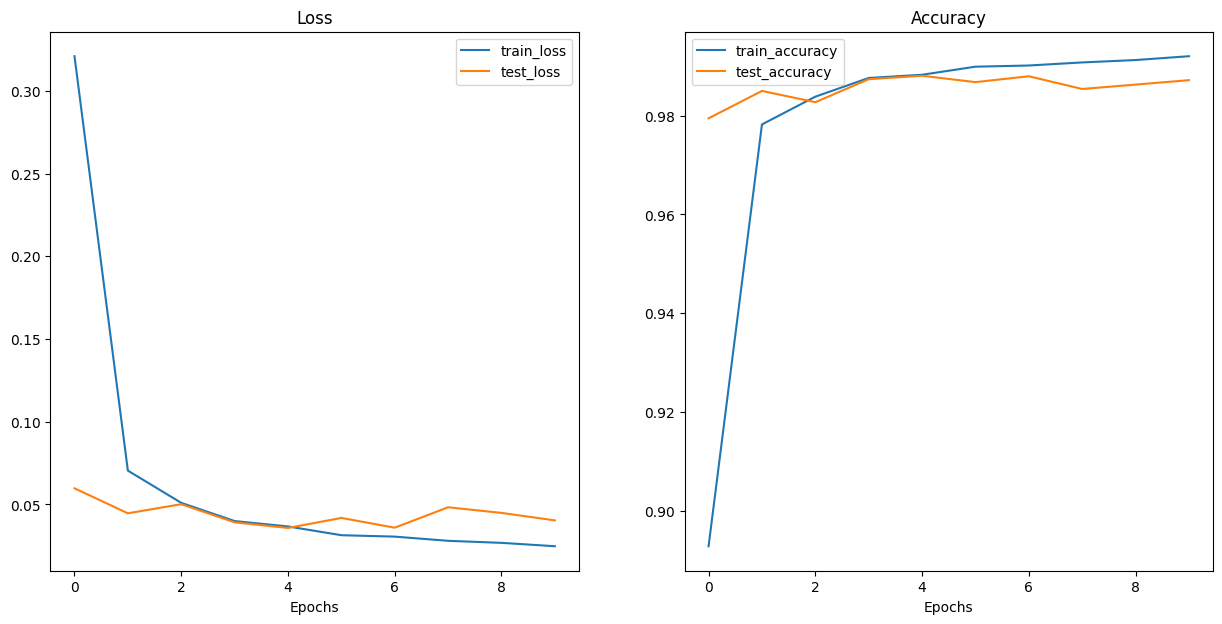


current exp / total: 4 / 8
Training with: lr: 0.001, betas: (0.9, 0.999), eps: 1e-08, weight_decay: 0.001


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4065 | train_acc: 0.8663 | test_loss: 0.0734 | test_acc: 0.9758
Epoch: 2 | train_loss: 0.0759 | train_acc: 0.9764 | test_loss: 0.0459 | test_acc: 0.9838
Epoch: 3 | train_loss: 0.0525 | train_acc: 0.9837 | test_loss: 0.0475 | test_acc: 0.9841
Epoch: 4 | train_loss: 0.0436 | train_acc: 0.9864 | test_loss: 0.0472 | test_acc: 0.9854
Epoch: 5 | train_loss: 0.0371 | train_acc: 0.9885 | test_loss: 0.0338 | test_acc: 0.9880
Epoch: 6 | train_loss: 0.0322 | train_acc: 0.9899 | test_loss: 0.0269 | test_acc: 0.9913
Epoch: 7 | train_loss: 0.0295 | train_acc: 0.9908 | test_loss: 0.0330 | test_acc: 0.9882
Epoch: 8 | train_loss: 0.0273 | train_acc: 0.9916 | test_loss: 0.0391 | test_acc: 0.9868
Epoch: 9 | train_loss: 0.0273 | train_acc: 0.9909 | test_loss: 0.0297 | test_acc: 0.9894
Epoch: 10 | train_loss: 0.0256 | train_acc: 0.9918 | test_loss: 0.0296 | test_acc: 0.9901
Epoch: 11 | train_loss: 0.0250 | train_acc: 0.9921 | test_loss: 0.0268 | test_acc: 0.9905
Epoch: 12 | train_l

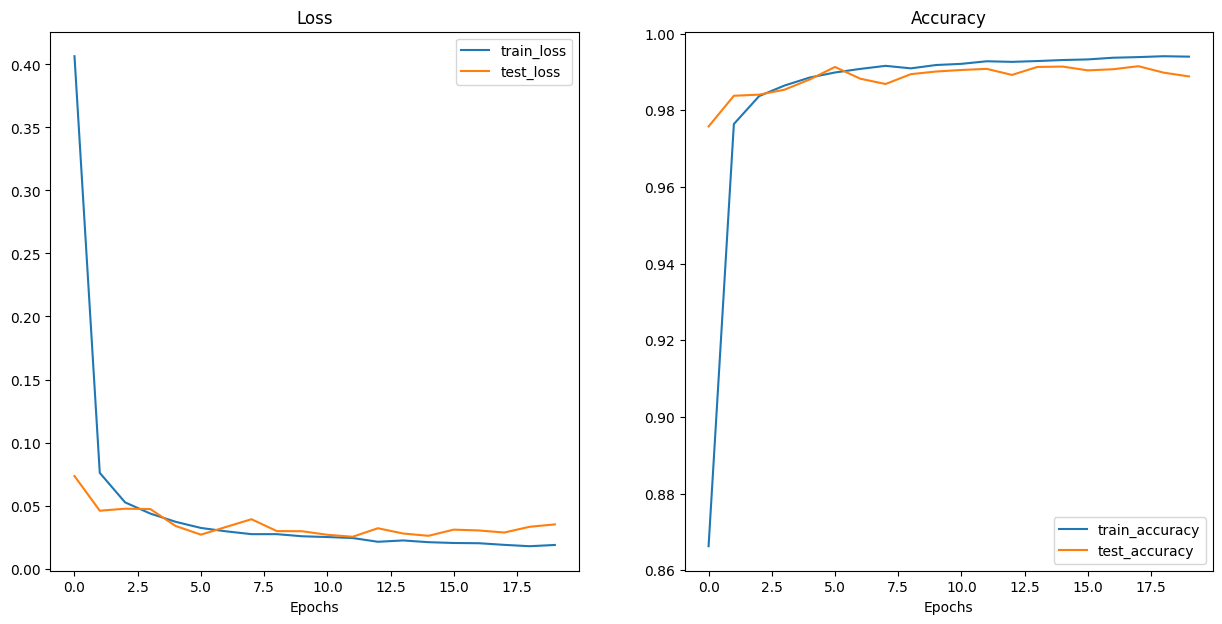


current exp / total: 5 / 8
Training with: lr: 0.0001, betas: (0.8, 0.888), eps: 1e-08, weight_decay: 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2060 | train_acc: 0.6204 | test_loss: 0.3965 | test_acc: 0.8781
Epoch: 2 | train_loss: 0.3049 | train_acc: 0.9046 | test_loss: 0.2094 | test_acc: 0.9372
Epoch: 3 | train_loss: 0.1943 | train_acc: 0.9398 | test_loss: 0.1676 | test_acc: 0.9478
Epoch: 4 | train_loss: 0.1478 | train_acc: 0.9551 | test_loss: 0.1302 | test_acc: 0.9584
Epoch: 5 | train_loss: 0.1199 | train_acc: 0.9632 | test_loss: 0.1043 | test_acc: 0.9657
Epoch: 6 | train_loss: 0.1005 | train_acc: 0.9690 | test_loss: 0.0952 | test_acc: 0.9692
Epoch: 7 | train_loss: 0.0867 | train_acc: 0.9736 | test_loss: 0.0714 | test_acc: 0.9766
Epoch: 8 | train_loss: 0.0762 | train_acc: 0.9764 | test_loss: 0.0705 | test_acc: 0.9771
Epoch: 9 | train_loss: 0.0685 | train_acc: 0.9784 | test_loss: 0.0571 | test_acc: 0.9823
Epoch: 10 | train_loss: 0.0629 | train_acc: 0.9807 | test_loss: 0.0644 | test_acc: 0.9785
total training time: 35.948 sec.
LOSS & Accuracy Curves
lr: 0.0001, betas: (0.8, 0.888), eps: 1e-08, weight_d

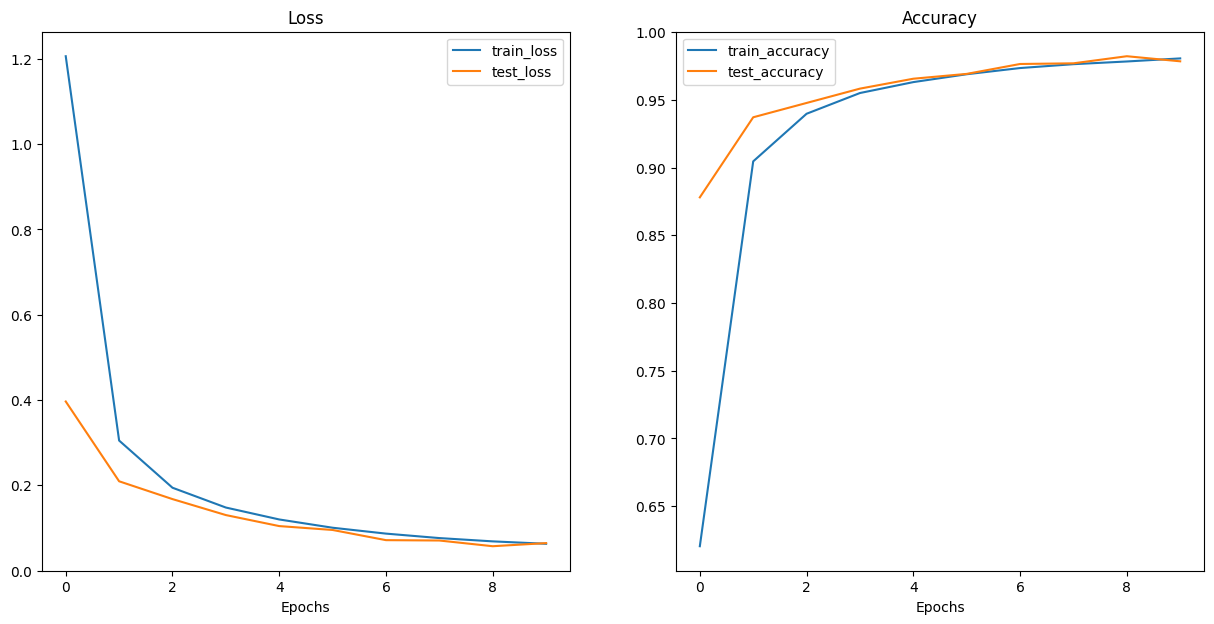


current exp / total: 6 / 8
Training with: lr: 0.0001, betas: (0.8, 0.888), eps: 1e-08, weight_decay: 0.001


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1451 | train_acc: 0.6348 | test_loss: 0.3362 | test_acc: 0.9003
Epoch: 2 | train_loss: 0.2663 | train_acc: 0.9189 | test_loss: 0.1910 | test_acc: 0.9435
Epoch: 3 | train_loss: 0.1680 | train_acc: 0.9490 | test_loss: 0.1269 | test_acc: 0.9615
Epoch: 4 | train_loss: 0.1265 | train_acc: 0.9606 | test_loss: 0.1170 | test_acc: 0.9615
Epoch: 5 | train_loss: 0.1040 | train_acc: 0.9679 | test_loss: 0.0902 | test_acc: 0.9703
Epoch: 6 | train_loss: 0.0889 | train_acc: 0.9723 | test_loss: 0.0785 | test_acc: 0.9765
Epoch: 7 | train_loss: 0.0800 | train_acc: 0.9751 | test_loss: 0.0713 | test_acc: 0.9774
Epoch: 8 | train_loss: 0.0718 | train_acc: 0.9774 | test_loss: 0.0665 | test_acc: 0.9794
Epoch: 9 | train_loss: 0.0645 | train_acc: 0.9798 | test_loss: 0.0575 | test_acc: 0.9807
Epoch: 10 | train_loss: 0.0599 | train_acc: 0.9816 | test_loss: 0.0541 | test_acc: 0.9818
Epoch: 11 | train_loss: 0.0561 | train_acc: 0.9825 | test_loss: 0.0539 | test_acc: 0.9823
Epoch: 12 | train_l

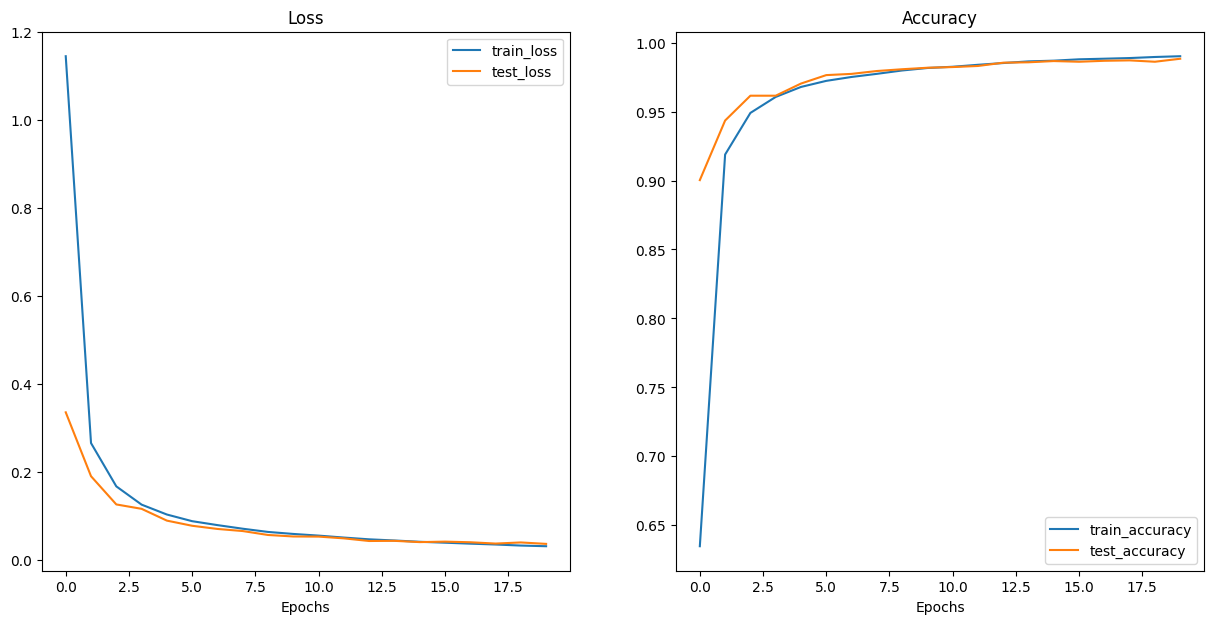


current exp / total: 7 / 8
Training with: lr: 0.0001, betas: (0.9, 0.999), eps: 1e-08, weight_decay: 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0062 | train_acc: 0.6617 | test_loss: 0.2619 | test_acc: 0.9210
Epoch: 2 | train_loss: 0.2230 | train_acc: 0.9315 | test_loss: 0.1658 | test_acc: 0.9500
Epoch: 3 | train_loss: 0.1570 | train_acc: 0.9524 | test_loss: 0.1291 | test_acc: 0.9610
Epoch: 4 | train_loss: 0.1252 | train_acc: 0.9618 | test_loss: 0.1119 | test_acc: 0.9654
Epoch: 5 | train_loss: 0.1056 | train_acc: 0.9678 | test_loss: 0.0903 | test_acc: 0.9701
Epoch: 6 | train_loss: 0.0899 | train_acc: 0.9723 | test_loss: 0.0888 | test_acc: 0.9721
Epoch: 7 | train_loss: 0.0829 | train_acc: 0.9745 | test_loss: 0.0738 | test_acc: 0.9768
Epoch: 8 | train_loss: 0.0737 | train_acc: 0.9771 | test_loss: 0.0799 | test_acc: 0.9751
Epoch: 9 | train_loss: 0.0681 | train_acc: 0.9790 | test_loss: 0.0630 | test_acc: 0.9807
Epoch: 10 | train_loss: 0.0625 | train_acc: 0.9806 | test_loss: 0.0703 | test_acc: 0.9763
total training time: 36.162 sec.
LOSS & Accuracy Curves
lr: 0.0001, betas: (0.9, 0.999), eps: 1e-08, weight_d

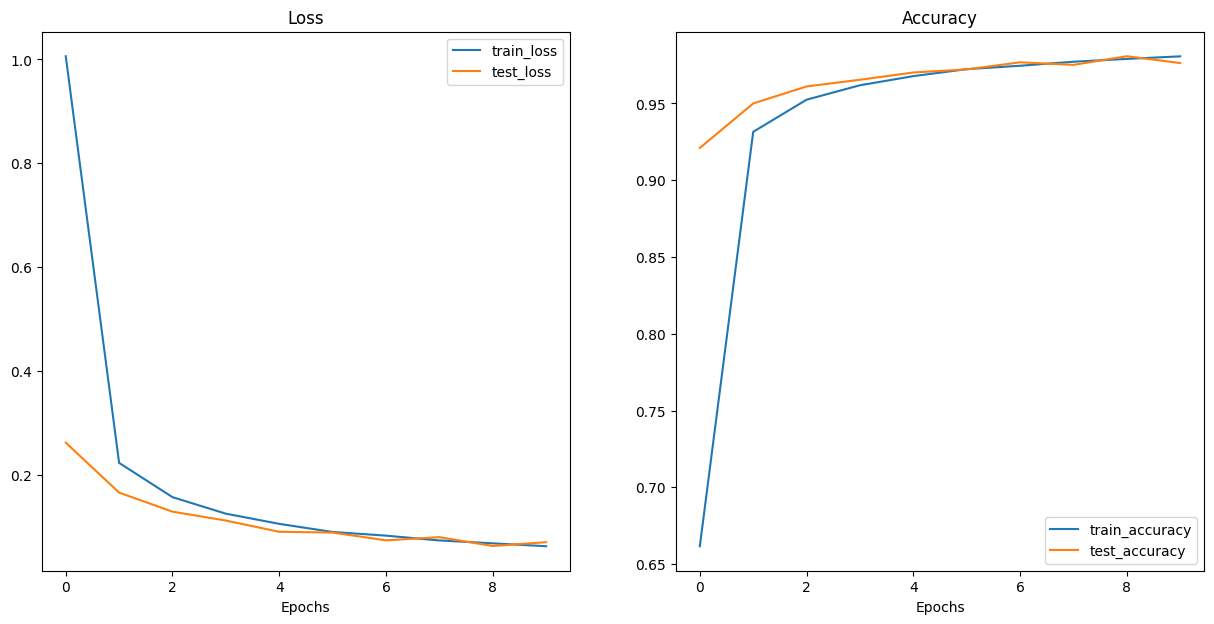


current exp / total: 8 / 8
Training with: lr: 0.0001, betas: (0.9, 0.999), eps: 1e-08, weight_decay: 0.001


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9554 | train_acc: 0.6859 | test_loss: 0.2913 | test_acc: 0.9061
Epoch: 2 | train_loss: 0.2342 | train_acc: 0.9287 | test_loss: 0.1564 | test_acc: 0.9517
Epoch: 3 | train_loss: 0.1504 | train_acc: 0.9539 | test_loss: 0.1143 | test_acc: 0.9639
Epoch: 4 | train_loss: 0.1156 | train_acc: 0.9642 | test_loss: 0.0908 | test_acc: 0.9721
Epoch: 5 | train_loss: 0.0951 | train_acc: 0.9707 | test_loss: 0.0941 | test_acc: 0.9710
Epoch: 6 | train_loss: 0.0828 | train_acc: 0.9740 | test_loss: 0.0710 | test_acc: 0.9767
Epoch: 7 | train_loss: 0.0738 | train_acc: 0.9768 | test_loss: 0.0785 | test_acc: 0.9756
Epoch: 8 | train_loss: 0.0667 | train_acc: 0.9795 | test_loss: 0.0550 | test_acc: 0.9836
Epoch: 9 | train_loss: 0.0626 | train_acc: 0.9810 | test_loss: 0.0533 | test_acc: 0.9831
Epoch: 10 | train_loss: 0.0579 | train_acc: 0.9813 | test_loss: 0.0573 | test_acc: 0.9819
Epoch: 11 | train_loss: 0.0541 | train_acc: 0.9827 | test_loss: 0.0556 | test_acc: 0.9823
Epoch: 12 | train_l

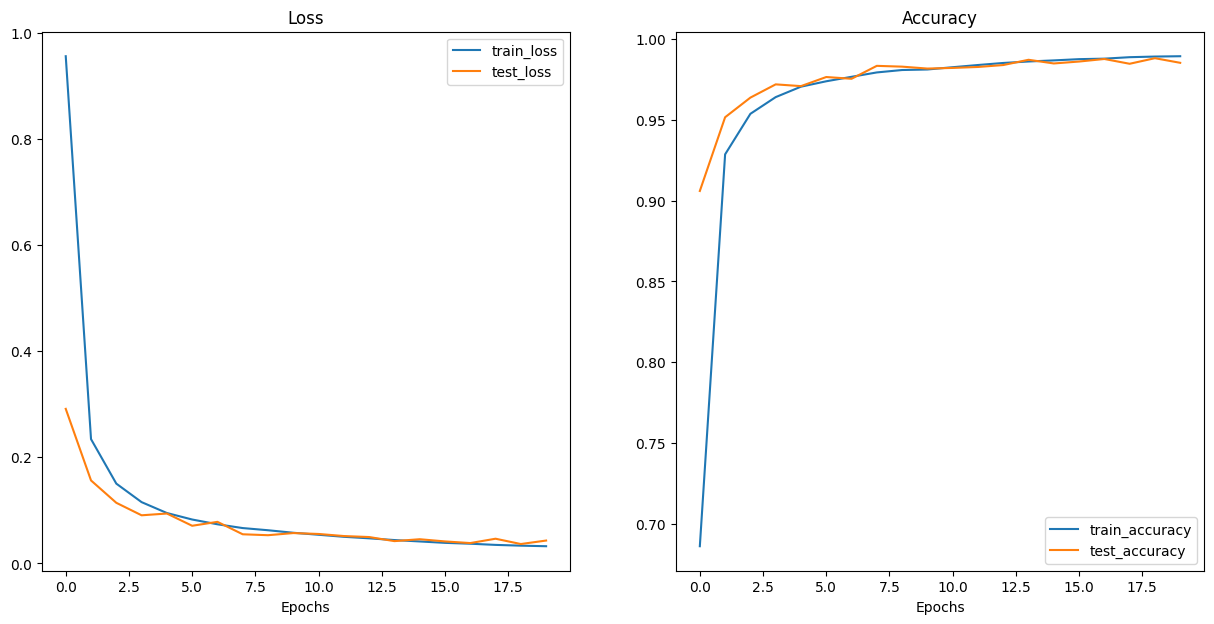

In [67]:
cur,total = 1, len(lr)*len(betas)*len(eps)*len(weight_decay)*len(epoches)
for h_parms in parms_combs:
  ### INIT MODEL STARTS ###
  # traning same model for each parms
  model_conv = get_custom_model().to(device=device)
  ### INIT MODEL END ###

  optimizer = torch.optim.Adam(
      params=model_conv.parameters(), lr=h_parms[0], betas=h_parms[1], eps=h_parms[2],weight_decay=h_parms[3]
  )

  # importing and init. the timer for checking model training time
  from timeit import default_timer as timer

  start_time = timer()
  print(f"current exp / total: {cur} / {total}")
  print(f"Training with: lr: {h_parms[0]}, betas: {h_parms[1]}, eps: {h_parms[2]}, weight_decay: {h_parms[3]}")
  

  # train model
  model_conv_results = train(
      model=model_conv,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      acc_fn=acc_fn,
      epochs=h_parms[4],
      save_info=f"lr_{h_parms[0]}_betas_{h_parms[1]}_eps_{h_parms[2]}_weight_decay_{h_parms[3]}",
  )

  # end timer
  end_time = timer()
  # printing time taken
  print(f"total training time: {end_time-start_time:.3f} sec.")
  # print("model stats:")
  # print(model_0_results)
  print(f"LOSS & Accuracy Curves\n"
        f"lr: {h_parms[0]}, betas: {h_parms[1]}, eps: {h_parms[2]}, weight_decay: {h_parms[3]}")
  plot_loss_curves(model_conv_results)
  cur+=1
  print()

### Training Resnet-18

current exp / total: 1 / 8
Training with: lr: 0.001, betas: (0.8, 0.888), eps: 1e-08, weight_decay: 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1465 | train_acc: 0.9564 | test_loss: 0.2717 | test_acc: 0.9174
Epoch: 2 | train_loss: 0.0759 | train_acc: 0.9785 | test_loss: 0.0965 | test_acc: 0.9704
Epoch: 3 | train_loss: 0.0616 | train_acc: 0.9825 | test_loss: 0.0693 | test_acc: 0.9794
Epoch: 4 | train_loss: 0.0533 | train_acc: 0.9848 | test_loss: 0.0385 | test_acc: 0.9878
Epoch: 5 | train_loss: 0.0457 | train_acc: 0.9874 | test_loss: 0.0550 | test_acc: 0.9832
Epoch: 6 | train_loss: 0.0399 | train_acc: 0.9890 | test_loss: 0.0459 | test_acc: 0.9867
Epoch: 7 | train_loss: 0.0375 | train_acc: 0.9895 | test_loss: 0.0446 | test_acc: 0.9873
Epoch: 8 | train_loss: 0.0368 | train_acc: 0.9896 | test_loss: 0.0580 | test_acc: 0.9845
Epoch: 9 | train_loss: 0.0350 | train_acc: 0.9904 | test_loss: 0.0426 | test_acc: 0.9878
Epoch: 10 | train_loss: 0.0322 | train_acc: 0.9908 | test_loss: 0.0335 | test_acc: 0.9898
total training time: 70.377 sec.
LOSS & Accuracy Curves
lr: 0.001, betas: (0.8, 0.888), eps: 1e-08, weight_de

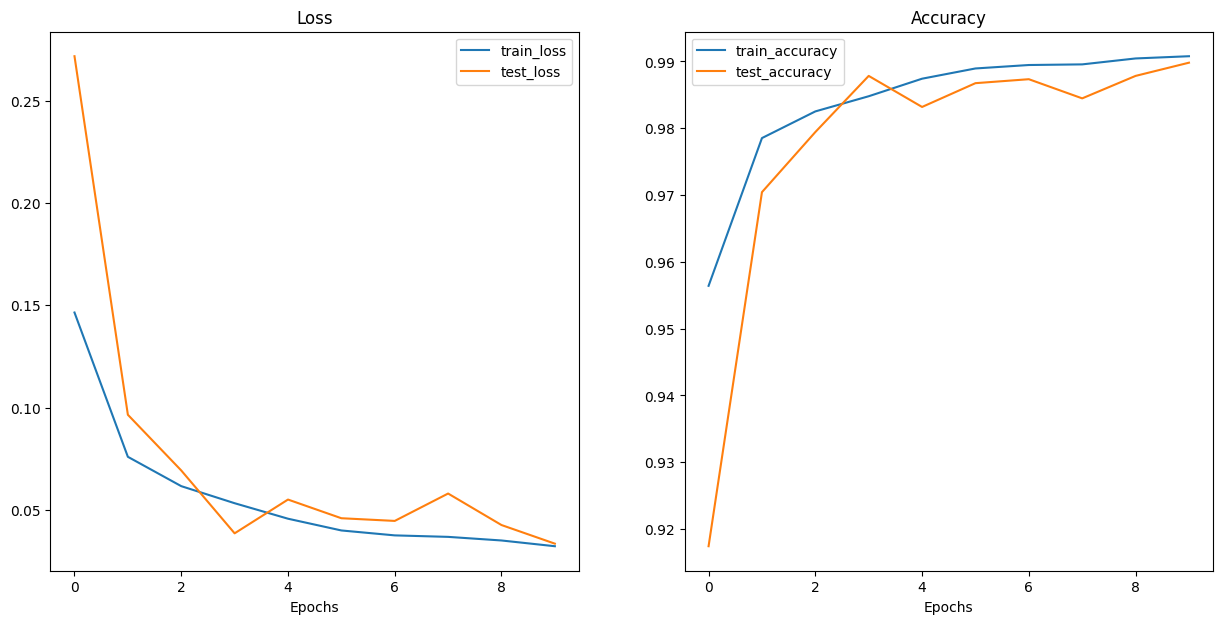


current exp / total: 2 / 8
Training with: lr: 0.001, betas: (0.8, 0.888), eps: 1e-08, weight_decay: 0.001


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1510 | train_acc: 0.9549 | test_loss: 0.1195 | test_acc: 0.9642
Epoch: 2 | train_loss: 0.0753 | train_acc: 0.9777 | test_loss: 0.0727 | test_acc: 0.9772
Epoch: 3 | train_loss: 0.0606 | train_acc: 0.9831 | test_loss: 0.0645 | test_acc: 0.9796
Epoch: 4 | train_loss: 0.0518 | train_acc: 0.9849 | test_loss: 0.0608 | test_acc: 0.9829
Epoch: 5 | train_loss: 0.0454 | train_acc: 0.9877 | test_loss: 0.0708 | test_acc: 0.9805
Epoch: 6 | train_loss: 0.0410 | train_acc: 0.9883 | test_loss: 0.0382 | test_acc: 0.9887
Epoch: 7 | train_loss: 0.0385 | train_acc: 0.9889 | test_loss: 0.0332 | test_acc: 0.9900
Epoch: 8 | train_loss: 0.0356 | train_acc: 0.9900 | test_loss: 0.0387 | test_acc: 0.9891
Epoch: 9 | train_loss: 0.0327 | train_acc: 0.9912 | test_loss: 0.1001 | test_acc: 0.9715
Epoch: 10 | train_loss: 0.0338 | train_acc: 0.9903 | test_loss: 0.0344 | test_acc: 0.9907
Epoch: 11 | train_loss: 0.0301 | train_acc: 0.9920 | test_loss: 0.0677 | test_acc: 0.9815
Epoch: 12 | train_l

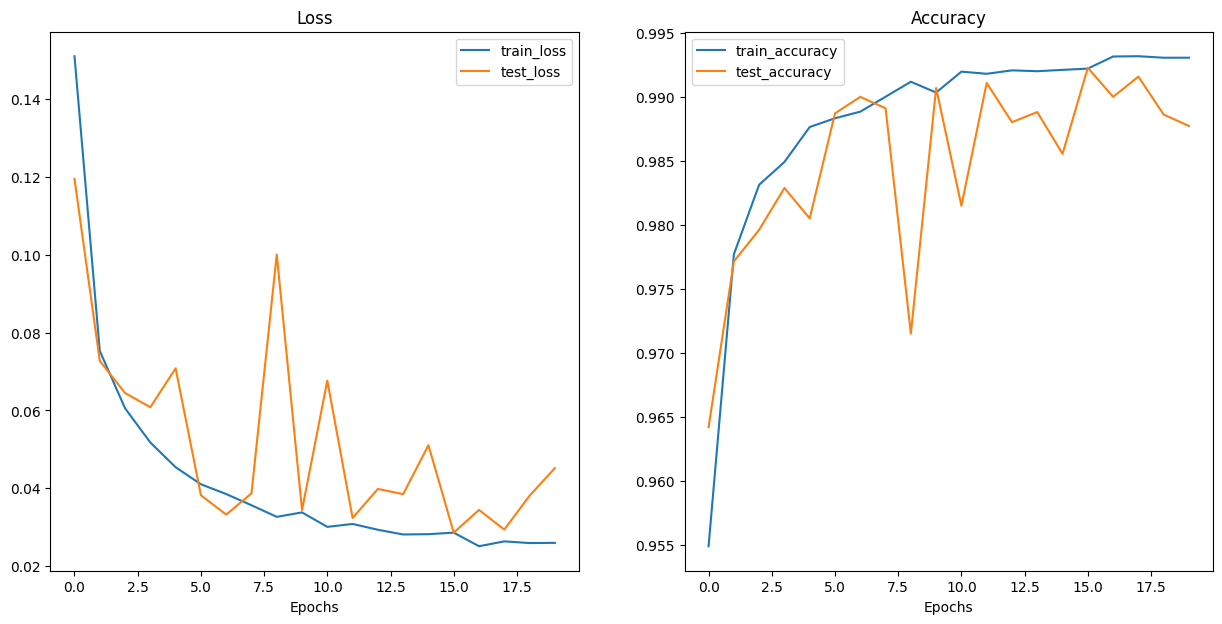


current exp / total: 3 / 8
Training with: lr: 0.001, betas: (0.9, 0.999), eps: 1e-08, weight_decay: 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1249 | train_acc: 0.9616 | test_loss: 0.0706 | test_acc: 0.9781
Epoch: 2 | train_loss: 0.0664 | train_acc: 0.9805 | test_loss: 0.1239 | test_acc: 0.9608
Epoch: 3 | train_loss: 0.0591 | train_acc: 0.9831 | test_loss: 0.0772 | test_acc: 0.9775
Epoch: 4 | train_loss: 0.0593 | train_acc: 0.9838 | test_loss: 0.0723 | test_acc: 0.9791
Epoch: 5 | train_loss: 0.0520 | train_acc: 0.9857 | test_loss: 0.0545 | test_acc: 0.9851
Epoch: 6 | train_loss: 0.0515 | train_acc: 0.9857 | test_loss: 0.0913 | test_acc: 0.9749
Epoch: 7 | train_loss: 0.0468 | train_acc: 0.9868 | test_loss: 0.0634 | test_acc: 0.9811
Epoch: 8 | train_loss: 0.0418 | train_acc: 0.9889 | test_loss: 0.0396 | test_acc: 0.9893
Epoch: 9 | train_loss: 0.0391 | train_acc: 0.9893 | test_loss: 0.0335 | test_acc: 0.9907
Epoch: 10 | train_loss: 0.0369 | train_acc: 0.9896 | test_loss: 0.0604 | test_acc: 0.9810
total training time: 70.778 sec.
LOSS & Accuracy Curves
lr: 0.001, betas: (0.9, 0.999), eps: 1e-08, weight_de

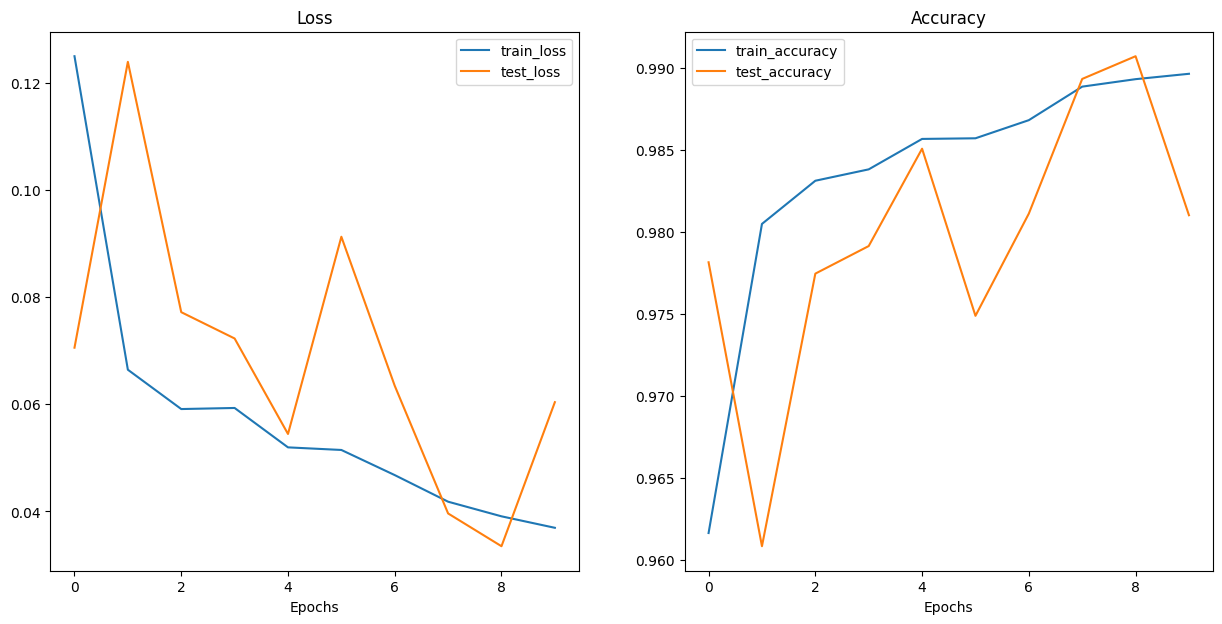


current exp / total: 4 / 8
Training with: lr: 0.001, betas: (0.9, 0.999), eps: 1e-08, weight_decay: 0.001


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1274 | train_acc: 0.9607 | test_loss: 0.0663 | test_acc: 0.9802
Epoch: 2 | train_loss: 0.0650 | train_acc: 0.9810 | test_loss: 0.0729 | test_acc: 0.9788
Epoch: 3 | train_loss: 0.0603 | train_acc: 0.9825 | test_loss: 0.0866 | test_acc: 0.9753
Epoch: 4 | train_loss: 0.0570 | train_acc: 0.9842 | test_loss: 0.0547 | test_acc: 0.9862
Epoch: 5 | train_loss: 0.0520 | train_acc: 0.9854 | test_loss: 0.0416 | test_acc: 0.9876
Epoch: 6 | train_loss: 0.0496 | train_acc: 0.9866 | test_loss: 0.0669 | test_acc: 0.9812
Epoch: 7 | train_loss: 0.0449 | train_acc: 0.9880 | test_loss: 0.0612 | test_acc: 0.9825
Epoch: 8 | train_loss: 0.0425 | train_acc: 0.9881 | test_loss: 0.0383 | test_acc: 0.9900
Epoch: 9 | train_loss: 0.0419 | train_acc: 0.9888 | test_loss: 0.0515 | test_acc: 0.9849
Epoch: 10 | train_loss: 0.0367 | train_acc: 0.9900 | test_loss: 0.0416 | test_acc: 0.9874
Epoch: 11 | train_loss: 0.0351 | train_acc: 0.9903 | test_loss: 0.0440 | test_acc: 0.9883
Epoch: 12 | train_l

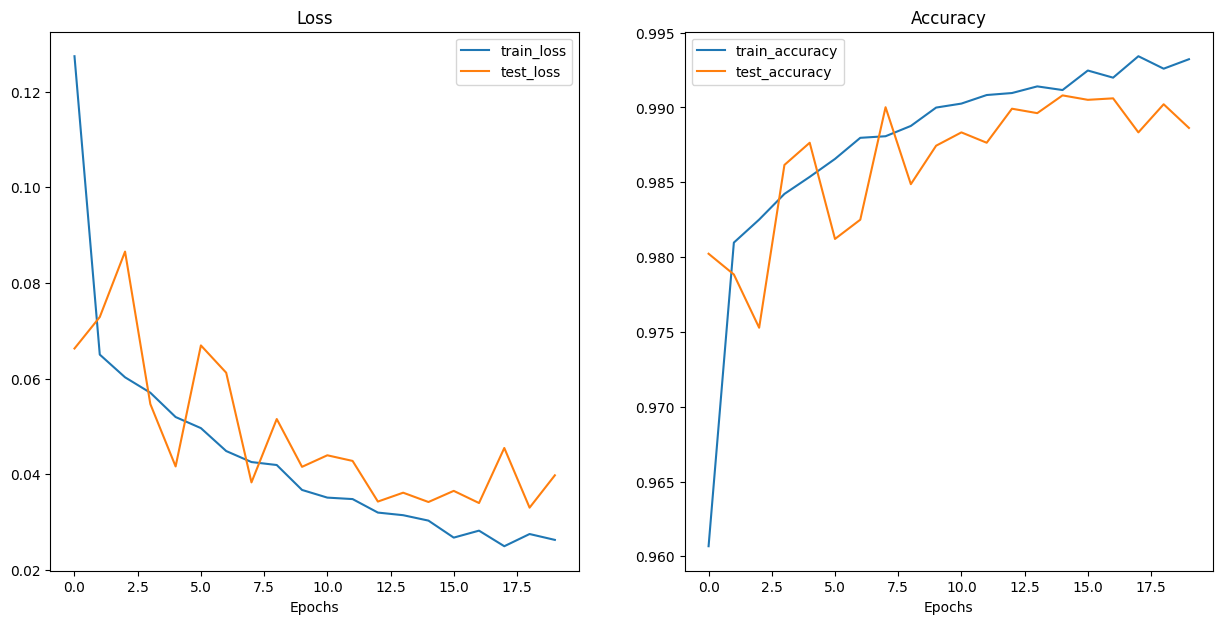


current exp / total: 5 / 8
Training with: lr: 0.0001, betas: (0.8, 0.888), eps: 1e-08, weight_decay: 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1676 | train_acc: 0.9496 | test_loss: 0.0606 | test_acc: 0.9802
Epoch: 2 | train_loss: 0.0484 | train_acc: 0.9850 | test_loss: 0.0500 | test_acc: 0.9839
Epoch: 3 | train_loss: 0.0308 | train_acc: 0.9903 | test_loss: 0.0513 | test_acc: 0.9838
Epoch: 4 | train_loss: 0.0249 | train_acc: 0.9920 | test_loss: 0.0408 | test_acc: 0.9878
Epoch: 5 | train_loss: 0.0215 | train_acc: 0.9932 | test_loss: 0.0406 | test_acc: 0.9876
Epoch: 6 | train_loss: 0.0197 | train_acc: 0.9936 | test_loss: 0.0383 | test_acc: 0.9884
Epoch: 7 | train_loss: 0.0165 | train_acc: 0.9948 | test_loss: 0.0412 | test_acc: 0.9883
Epoch: 8 | train_loss: 0.0163 | train_acc: 0.9949 | test_loss: 0.0395 | test_acc: 0.9884
Epoch: 9 | train_loss: 0.0139 | train_acc: 0.9955 | test_loss: 0.0367 | test_acc: 0.9893
Epoch: 10 | train_loss: 0.0142 | train_acc: 0.9953 | test_loss: 0.0479 | test_acc: 0.9878
total training time: 70.034 sec.
LOSS & Accuracy Curves
lr: 0.0001, betas: (0.8, 0.888), eps: 1e-08, weight_d

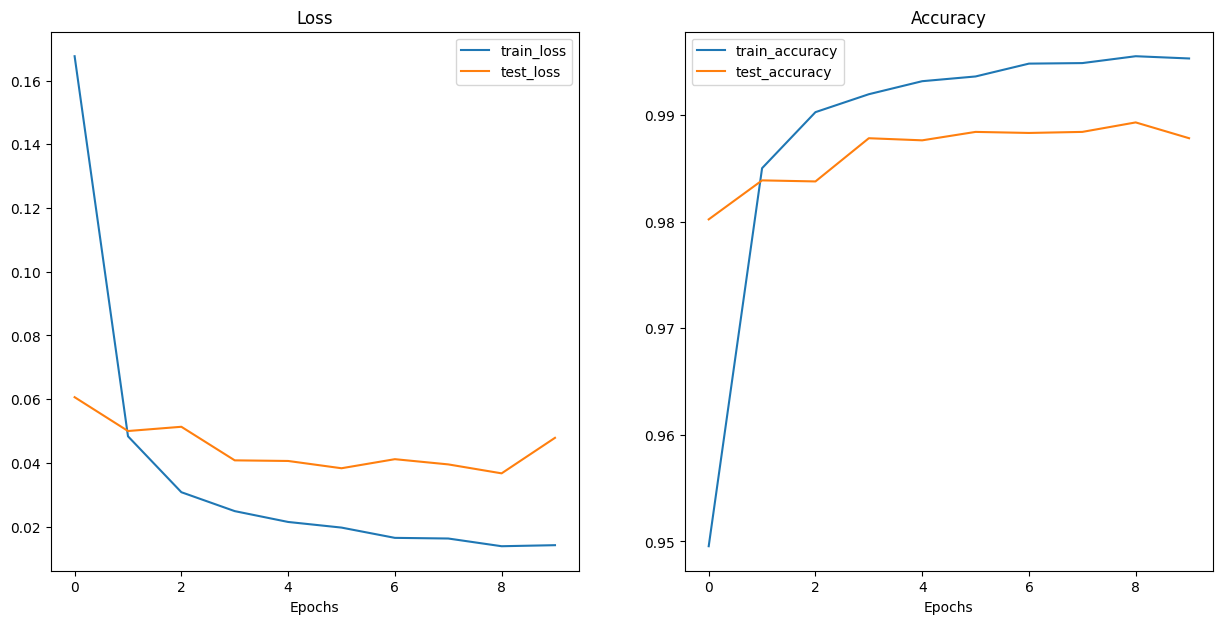


current exp / total: 6 / 8
Training with: lr: 0.0001, betas: (0.8, 0.888), eps: 1e-08, weight_decay: 0.001


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1687 | train_acc: 0.9488 | test_loss: 0.0626 | test_acc: 0.9808
Epoch: 2 | train_loss: 0.0473 | train_acc: 0.9855 | test_loss: 0.0547 | test_acc: 0.9821
Epoch: 3 | train_loss: 0.0335 | train_acc: 0.9895 | test_loss: 0.0407 | test_acc: 0.9866
Epoch: 4 | train_loss: 0.0266 | train_acc: 0.9919 | test_loss: 0.0436 | test_acc: 0.9864
Epoch: 5 | train_loss: 0.0212 | train_acc: 0.9935 | test_loss: 0.0405 | test_acc: 0.9885
Epoch: 6 | train_loss: 0.0189 | train_acc: 0.9942 | test_loss: 0.0357 | test_acc: 0.9889
Epoch: 7 | train_loss: 0.0172 | train_acc: 0.9943 | test_loss: 0.0432 | test_acc: 0.9884
Epoch: 8 | train_loss: 0.0171 | train_acc: 0.9948 | test_loss: 0.0435 | test_acc: 0.9871
Epoch: 9 | train_loss: 0.0164 | train_acc: 0.9951 | test_loss: 0.0403 | test_acc: 0.9885
Epoch: 10 | train_loss: 0.0145 | train_acc: 0.9956 | test_loss: 0.0368 | test_acc: 0.9887
Epoch: 11 | train_loss: 0.0136 | train_acc: 0.9960 | test_loss: 0.0382 | test_acc: 0.9894
Epoch: 12 | train_l

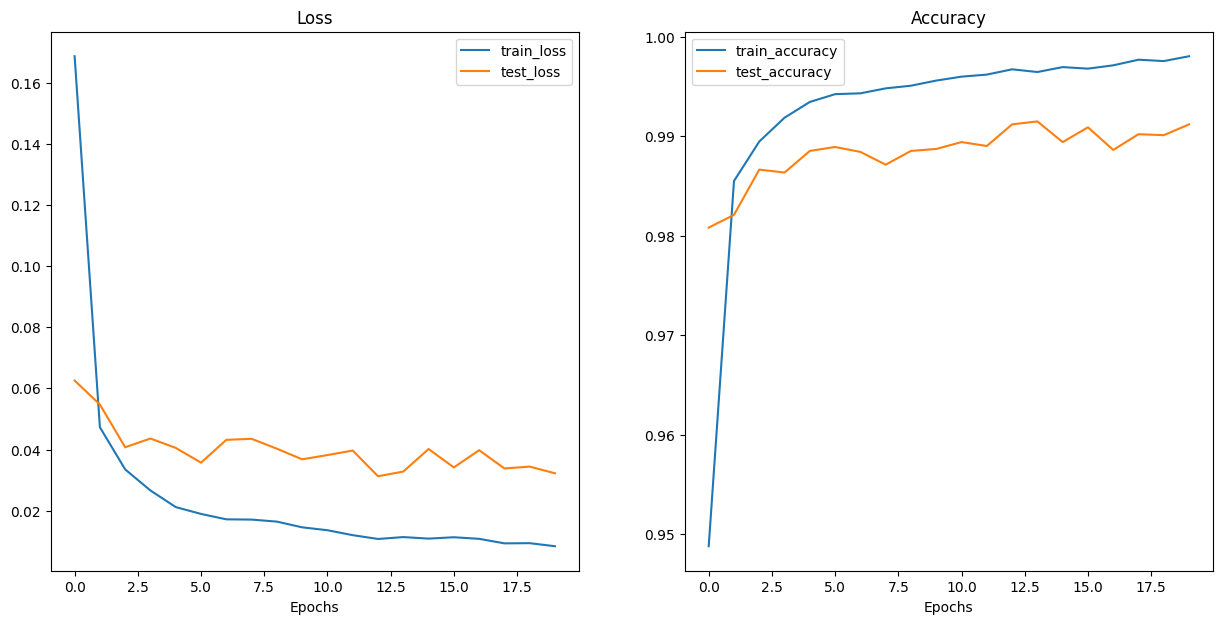


current exp / total: 7 / 8
Training with: lr: 0.0001, betas: (0.9, 0.999), eps: 1e-08, weight_decay: 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1682 | train_acc: 0.9491 | test_loss: 0.0586 | test_acc: 0.9813
Epoch: 2 | train_loss: 0.0414 | train_acc: 0.9877 | test_loss: 0.0499 | test_acc: 0.9827
Epoch: 3 | train_loss: 0.0287 | train_acc: 0.9910 | test_loss: 0.0597 | test_acc: 0.9805
Epoch: 4 | train_loss: 0.0215 | train_acc: 0.9927 | test_loss: 0.0442 | test_acc: 0.9872
Epoch: 5 | train_loss: 0.0214 | train_acc: 0.9930 | test_loss: 0.0547 | test_acc: 0.9837
Epoch: 6 | train_loss: 0.0156 | train_acc: 0.9952 | test_loss: 0.0410 | test_acc: 0.9866
Epoch: 7 | train_loss: 0.0161 | train_acc: 0.9945 | test_loss: 0.0466 | test_acc: 0.9865
Epoch: 8 | train_loss: 0.0155 | train_acc: 0.9951 | test_loss: 0.0507 | test_acc: 0.9841
Epoch: 9 | train_loss: 0.0144 | train_acc: 0.9952 | test_loss: 0.0364 | test_acc: 0.9892
Epoch: 10 | train_loss: 0.0165 | train_acc: 0.9949 | test_loss: 0.0405 | test_acc: 0.9890
total training time: 71.125 sec.
LOSS & Accuracy Curves
lr: 0.0001, betas: (0.9, 0.999), eps: 1e-08, weight_d

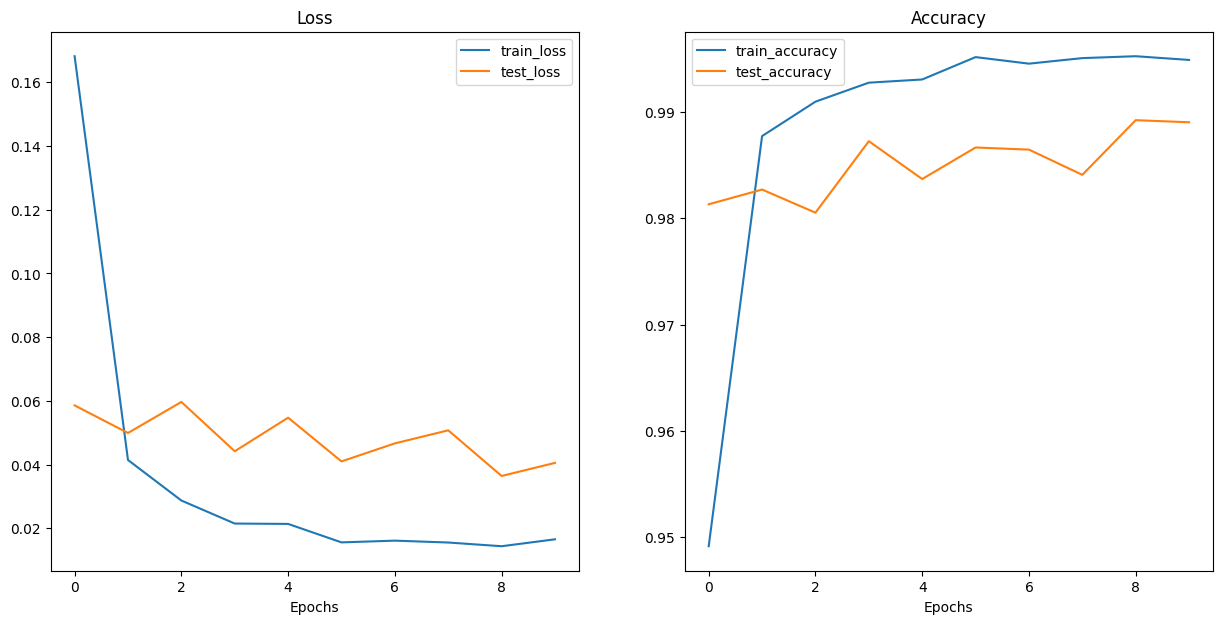


current exp / total: 8 / 8
Training with: lr: 0.0001, betas: (0.9, 0.999), eps: 1e-08, weight_decay: 0.001


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1728 | train_acc: 0.9472 | test_loss: 0.0666 | test_acc: 0.9791
Epoch: 2 | train_loss: 0.0442 | train_acc: 0.9863 | test_loss: 0.0575 | test_acc: 0.9814
Epoch: 3 | train_loss: 0.0272 | train_acc: 0.9911 | test_loss: 0.0560 | test_acc: 0.9824
Epoch: 4 | train_loss: 0.0219 | train_acc: 0.9929 | test_loss: 0.0495 | test_acc: 0.9849
Epoch: 5 | train_loss: 0.0190 | train_acc: 0.9942 | test_loss: 0.0490 | test_acc: 0.9852
Epoch: 6 | train_loss: 0.0187 | train_acc: 0.9938 | test_loss: 0.0435 | test_acc: 0.9880
Epoch: 7 | train_loss: 0.0162 | train_acc: 0.9951 | test_loss: 0.0381 | test_acc: 0.9889
Epoch: 8 | train_loss: 0.0139 | train_acc: 0.9959 | test_loss: 0.0604 | test_acc: 0.9822
Epoch: 9 | train_loss: 0.0162 | train_acc: 0.9948 | test_loss: 0.0464 | test_acc: 0.9867
Epoch: 10 | train_loss: 0.0156 | train_acc: 0.9951 | test_loss: 0.0529 | test_acc: 0.9856
Epoch: 11 | train_loss: 0.0146 | train_acc: 0.9955 | test_loss: 0.0374 | test_acc: 0.9889
Epoch: 12 | train_l

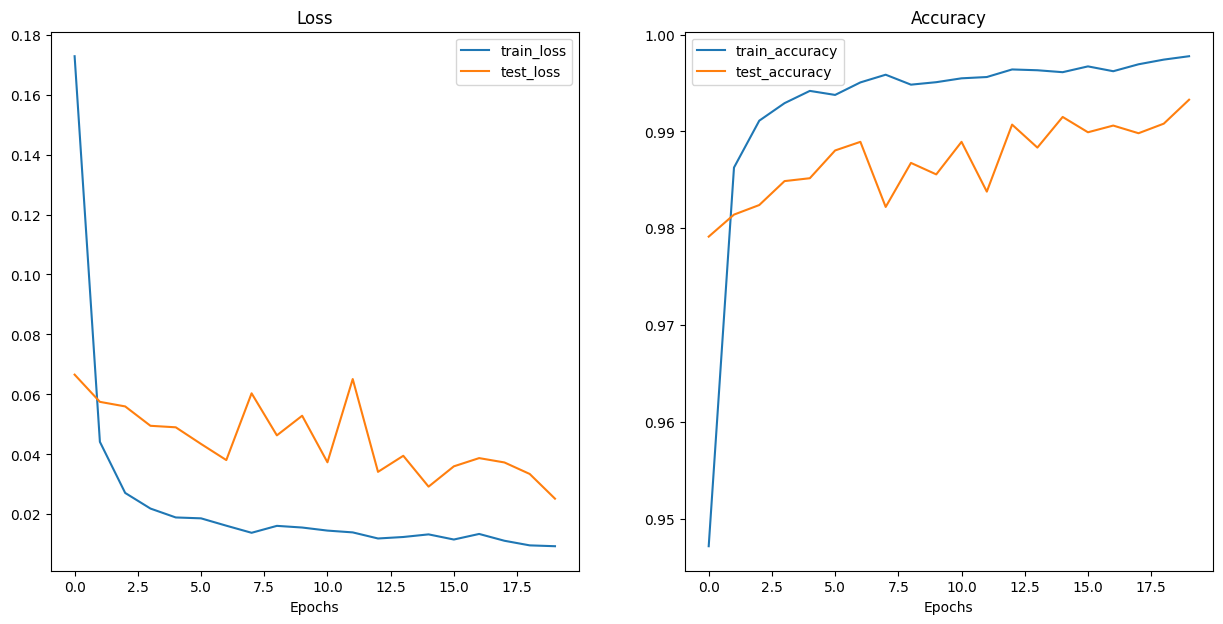

In [68]:
cur,total = 1, len(lr)*len(betas)*len(eps)*len(weight_decay)*len(epoches)
for h_parms in parms_combs:
  ### INIT MODEL STARTS ###
  # traning same model for each parms
  model_resnet = get_resnet_model().to(device=device)
  ### INIT MODEL END ###

  optimizer = torch.optim.Adam(
      params=model_resnet.parameters(), lr=h_parms[0], betas=h_parms[1], eps=h_parms[2],weight_decay=h_parms[3]
  )

  # importing and init. the timer for checking model training time
  from timeit import default_timer as timer

  start_time = timer()
  print(f"current exp / total: {cur} / {total}")
  print(f"Training with: lr: {h_parms[0]}, betas: {h_parms[1]}, eps: {h_parms[2]}, weight_decay: {h_parms[3]}")
  

  # train model
  model_resnet_results = train(
      model=model_resnet,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      acc_fn=acc_fn,
      epochs=h_parms[4],
      save_info=f"lr_{h_parms[0]}_betas_{h_parms[1]}_eps_{h_parms[2]}_weight_decay_{h_parms[3]}",
  )

  # end timer
  end_time = timer()
  # printing time taken
  print(f"total training time: {end_time-start_time:.3f} sec.")
  # print("model stats:")
  # print(model_0_results)
  print(f"LOSS & Accuracy Curves\n"
        f"lr: {h_parms[0]}, betas: {h_parms[1]}, eps: {h_parms[2]}, weight_decay: {h_parms[3]}")
  plot_loss_curves(model_resnet_results)
  cur+=1
  print()

# Loading Best Performing model

## Custom Arch

In [53]:
model_name = "MNISTModel_epoch_20_optim_adam_lr_0.001_betas_(0.8, 0.888)_eps_1e-08_weight_decay_0.001.pth"

model_conv = get_custom_model().to(device=device)

model_conv.load_state_dict(torch.load(model_name))
model_conv.eval()

MNISTModel(
  (block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=288, o

In [54]:
# calculating confusion matrix
conf_matrix = torch.zeros(10,10)
for X,y in test_dataloader:
    X,y = X.to(device=device), y.to(device=device)
    y_preds = model_conv(X)
    # populating the confusion matrix
    for p,l in zip(y_preds.argmax(dim=1),y):
        conf_matrix[p,l] += 1
print(f"confusion matrix:\n{conf_matrix}")

confusion matrix:
tensor([[9.7400e+02, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
         3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.1330e+03, 7.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         3.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0190e+03, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0030e+03, 0.0000e+00, 3.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 9.6100e+02, 1.0000e+00,
         2.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 8.8300e+02,
         4.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00, 1.0000e+00,
         9.4500e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [

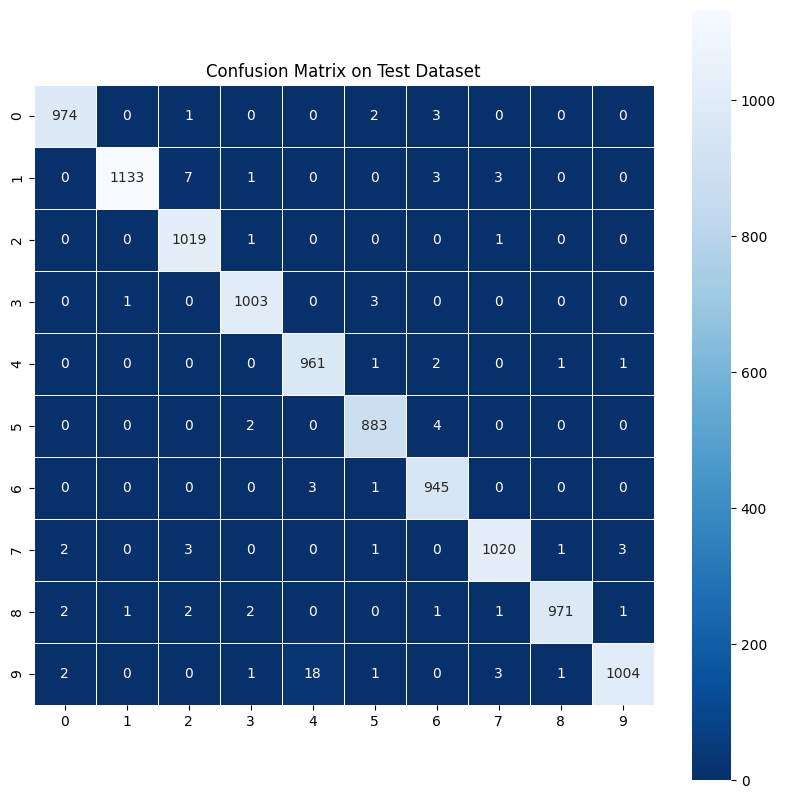

In [55]:
# plotting confusion matrix
import seaborn as sns
plt.figure(figsize=(10,10))
plt.title("Confusion Matrix on Test Dataset")
sns.heatmap(conf_matrix, annot=True, fmt=".0f", linewidths=0.5, square=True, cmap="Blues_r")
plt.show()


In [56]:
# calculating overall and classwise accuracy
print("overall and classwise accuracy:")
class_acc = []
for i in range(10):
    class_acc.append(conf_matrix[i,i]/conf_matrix[i].sum())
print(f"overall accuracy: {conf_matrix.diag().sum()/conf_matrix.sum()}")
for i in range(10):
    print(f"class {i} accuracy: {class_acc[i]}")

overall and classwise accuracy:
overall accuracy: 0.9912999868392944
class 0 accuracy: 0.9938775300979614
class 1 accuracy: 0.9877942204475403
class 2 accuracy: 0.9980411529541016
class 3 accuracy: 0.9960278272628784
class 4 accuracy: 0.9948239922523499
class 5 accuracy: 0.993250846862793
class 6 accuracy: 0.9957850575447083
class 7 accuracy: 0.9902912378311157
class 8 accuracy: 0.9898062944412231
class 9 accuracy: 0.9747572541236877


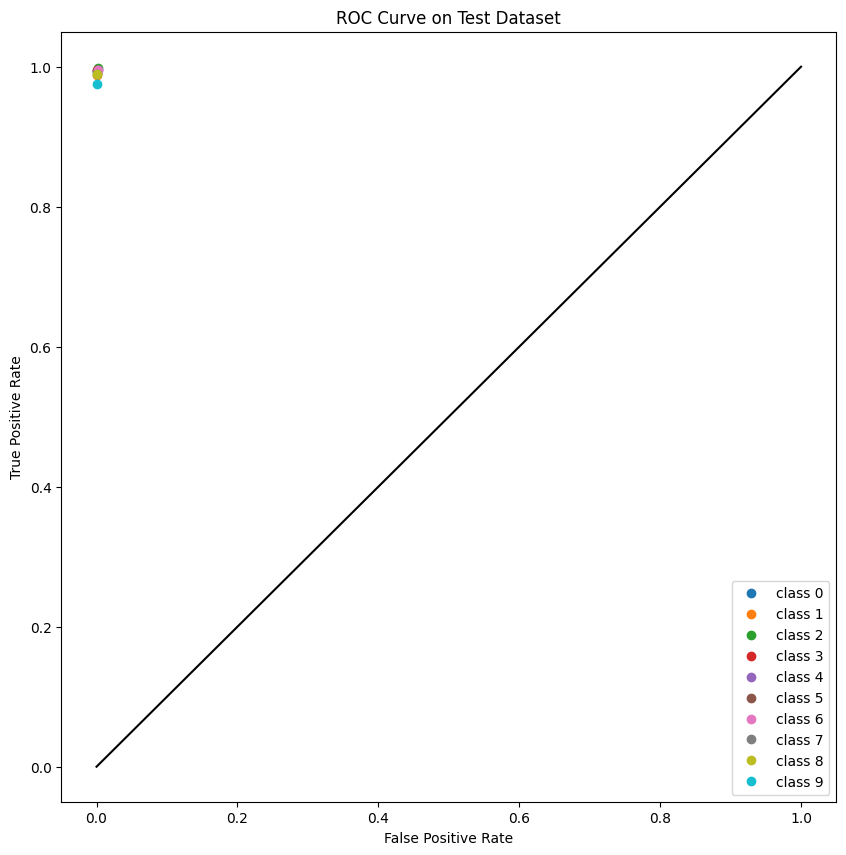

In [57]:
# plotting ROC curve
plt.figure(figsize=(10,10))
plt.title("ROC Curve on Test Dataset")
recalls = []
precision = []
for i in range(10):
    tp = conf_matrix[i,i]
    fn = conf_matrix[i].sum() - tp
    fp = conf_matrix[:,i].sum() - tp
    tn = conf_matrix.sum() - tp - fn - fp
    precision.append(tp/(tp+fp))
    recalls.append(tp/(tp+fn))
    plt.plot(fp/(fp+tn),tp/(tp+fn),"o",label=f"class {i}")
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0,1],[0,1],color="black")
plt.show()


## Resnet-18 Arch

In [58]:
model_name = "ResNet_epoch_20_optim_adam_lr_0.0001_betas_(0.9, 0.999)_eps_1e-08_weight_decay_0.001.pth"

model_resnet = get_resnet_model().to(device=device)

model_resnet.load_state_dict(torch.load(model_name))
model_resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [59]:
# calculating confusion matrix
conf_matrix = torch.zeros(10,10)
for X,y in test_dataloader:
    X,y = X.to(device=device), y.to(device=device)
    y_preds = model_resnet(X)
    # populating the confusion matrix
    for p,l in zip(y_preds.argmax(dim=1),y):
        conf_matrix[p,l] += 1
print(f"confusion matrix:\n{conf_matrix}")

confusion matrix:
tensor([[9.7500e+02, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 1.1300e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 1.0240e+03, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0040e+03, 0.0000e+00, 4.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 9.7500e+02, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00, 0.0000e+00, 8.8600e+02,
         3.0000e+00, 0.0000e+00, 1.0000e+00, 3.0000e+00],
        [0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 3.0000e+00, 1.0000e+00,
         9.4800e+02, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [

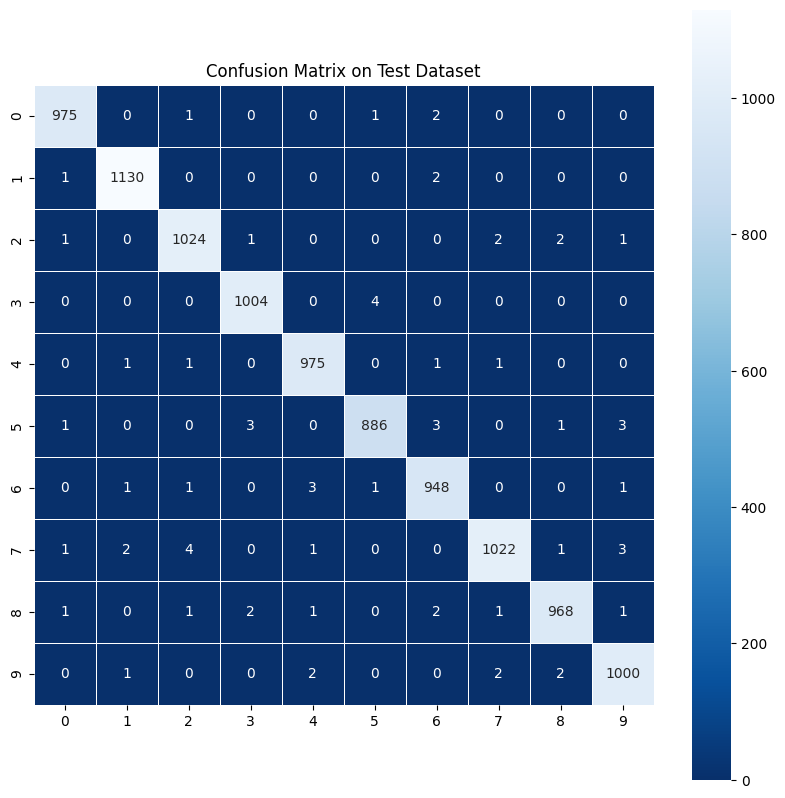

In [60]:
# plotting confusion matrix
import seaborn as sns
plt.figure(figsize=(10,10))
plt.title("Confusion Matrix on Test Dataset")
sns.heatmap(conf_matrix, annot=True, fmt=".0f", linewidths=0.5, square=True, cmap="Blues_r")
plt.show()


In [61]:
# calculating overall and classwise accuracy
print("overall and classwise accuracy:")
class_acc = []
for i in range(10):
    class_acc.append(conf_matrix[i,i]/conf_matrix[i].sum())
print(f"overall accuracy: {conf_matrix.diag().sum()/conf_matrix.sum()}")
for i in range(10):
    print(f"class {i} accuracy: {class_acc[i]}")

overall and classwise accuracy:
overall accuracy: 0.9932000041007996
class 0 accuracy: 0.9959142208099365
class 1 accuracy: 0.9973521828651428
class 2 accuracy: 0.99321049451828
class 3 accuracy: 0.9960317611694336
class 4 accuracy: 0.9959142208099365
class 5 accuracy: 0.9877368807792664
class 6 accuracy: 0.9926701784133911
class 7 accuracy: 0.988394558429718
class 8 accuracy: 0.9907881021499634
class 9 accuracy: 0.9930486679077148


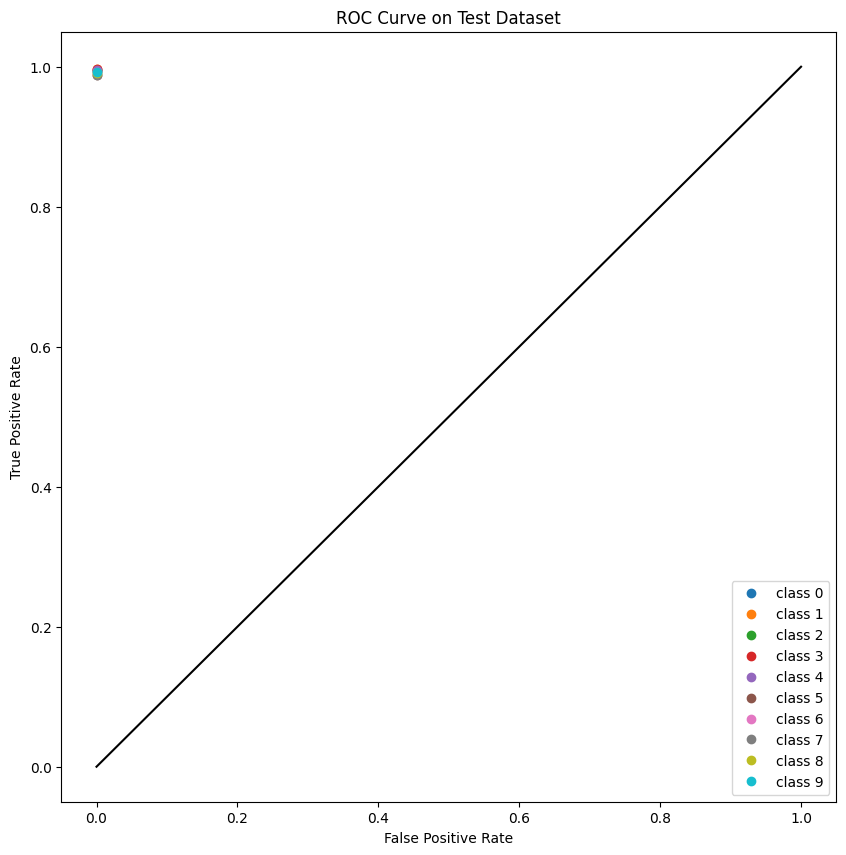

In [62]:
# plotting ROC curve
plt.figure(figsize=(10,10))
plt.title("ROC Curve on Test Dataset")
recalls = []
precision = []
for i in range(10):
    tp = conf_matrix[i,i]
    fn = conf_matrix[i].sum() - tp
    fp = conf_matrix[:,i].sum() - tp
    tn = conf_matrix.sum() - tp - fn - fp
    precision.append(tp/(tp+fp))
    recalls.append(tp/(tp+fn))
    plt.plot(fp/(fp+tn),tp/(tp+fn),"o",label=f"class {i}")
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0,1],[0,1],color="black")
plt.show()
